I was not able to get the bibtex integration for jupyter to work, so I am just putting the bibtex labels in brackets in the text: (examplecitation2024)

Scope:

This project aims to look into ways of characterizing a behavioural process with tools and parameters used in information theory.  
This can give more insight into the nature of the process and can in turn be used to create models trying to explain behaviour following similar processes.

Example of a coin flip:

To have an easy example for how to calculate and estimate the information theoretic measures, which we want to apply to a Markov process later on, we can try them out on a coin flip.
The general formula for Shannon entropy is as follows:
$$ H(X) = - \sum_{x_i \epsilon X} p(x_i) \log_2p(x_i). $$ 
The Shannon entropy of a coin flip can be simplified to the binary entropy formula, since there are only two possible outcomes:
$$ H(p) = - [p \log_2{p} + (1-p) \log_2(1-p)]. $$ 
One can also define the Shannon entropy for blocks of some length $L$, where each block is a sequence of $L$ consecutive observations of $s_i \epsilon S$ (cover1999elements):
$$ H(L) = -\sum_{s_i^L \epsilon S^L} P(s_i^L) \log_2P(s_i^L). $$ 
For a fair coin, the two possible observations each have a probability of $\frac{1}{2}$, meaning that sequences of length $L$ will all have probabilities of $(\frac{1}{2})^L$.
The total entropy of a measurement of length L then equals $$H(L) = - \sum_{s_i^L \epsilon S^L} (\frac{1}{2})^L \log_2(\frac{1}{2})^L = - 2^L (\frac{1}{2})^L \log_2(\frac{1}{2})^L =L$$, coming from the fact that there are allways $2^L$ different combinations one can achieve from observing a coin for $L$ consecutive flips.
This implies that the entropy rate is $$ h_{\mu} = \lim_{L \to \infty} \frac{H(L)}{L} = 1 $$ (also see https://wiki.santafe.edu/images/1/1d/ComplexityLecture1D.pdf, slide 8).  

With this, the excess entropy can be evaluated to $$E = \lim_{L \to \infty} (H(L) - h_{\mu}L) = \lim_{L \to \infty} (L-L) = 0$$ and finally the total transient information $$T = \sum_{L=0}^{\infty} E + h_{\mu}L - H(L) = \sum_{L=0}^{\infty} 0 = 0 .$$ 
(crutchfield2001synchronizing)
This means that in the case of a fair coin, there is no transient information for consecutive coin flips, an agent observing the system would instantly be synchronized and able to estimate the randomness of the system correctly.
This makes sense, since a coin flip is a binary system with distinct characteristics, implying instant synchronization.
It is important to note, that this assumes that the agent is able to estimate the entropy of the combinations perfectly.

But what about estimating the entropy of the coin flip itself, just by observing multiple consecutive ones?
A simple approach is to first estimate the probability $p$ of the binary outcome with the relative abundance $n_p$ in a given set of $L$ consecutive observations:
$$ \hat{p}_L = \frac{n_p}{L}. $$
This estimate can be plugged into the Shannon entropy formula, resulting in teh so called plug-in binary entropy estimator for a sequence of length L (conant1973estimation):

$$
\hat{H}_L(p) = H(\hat{p}_L) = -[\frac{n_p}{L} \log_2\frac{n_p}{L} + (1-\frac{n_p}{L}) \log_2(1-\frac{n_p}{L})],
$$
which converges to $H(p)$ for $L \to \infty$ (Law of large numbers).

Since this estimation is very different to calculating the block entropy $H(L)$, measures like excess entropy and transient information can not be reasonably defined in the same way.
For this estimation, "syncronization" as defined in (crutchfield2001synchronizing) would also be impossible, since the estimate only ever equals the true entropy in infinity.

Observing the delayed action MDP

The problem, which will be looked at in more detail, is a so-called "delayed action" experiment. One can picture an agent in a box, with a light switch, the light itself and a hatch through which a reward is given.
This setup can be described with the following Markov Decision Process (MDP), where $P_{ai}, P_{wi}, i = {0, 1, 2}$ denote the agent's policy to act or wait in a given state and $p_X$ is the base probability for the light to turn on when currently switched off.

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pygraphviz
import os
import pickle
#from network_viz_functions import create_lower_diGraph, create_upper_diGraph
#os.environ["R_HOME"] = "C:\\Users\\alexa\\anaconda3\\envs\\PS\\Lib\\R"
#import rpy2.robjects as ro
#%load_ext rpy2.ipython

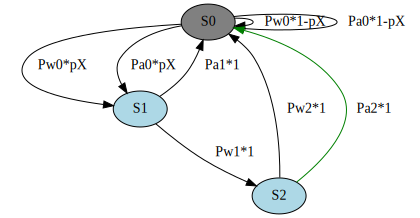

In [3]:
da_graph = nx.MultiDiGraph()
da_graph.add_nodes_from([("S0", {"fillcolor": "grey", "subset":0}), ("S1", {"fillcolor": "lightblue", "subset":0}), ("S2", {"fillcolor": "lightblue", "subset":0})])
edges = [("S0", "S1", "Pw0", {"p":"pX"}),
         ("S0", "S0", "Pw0", {"p":"1-pX"}),
         ("S0", "S1", "Pa0", {"p":"pX"}),
         ("S0", "S0", "Pa0", {"p":"1-pX"}),
         ("S1", "S2", "Pw1", {"p":1}),
         ("S1", "S0", "Pa1", {"p":1}),
         ("S2", "S0", "Pw2", {"p":1}),
         ("S2", "S0", "Pa2", {"p":1, "color": "green"})]
da_graph.add_edges_from(edges)
labels = {(edge[0], edge[1], edge[2]):str(edge[2] + "*" + str(edge[3]["p"]) + "   ") for edge in da_graph.edges(data = True, keys = True)}
nx.set_edge_attributes(da_graph, labels, "label")

D = nx.drawing.nx_agraph.to_agraph(da_graph)
D.node_attr.update(style = "filled")
D.layout('dot')

D

The agent now moves through the states according to its policy, but what is the result of this?
The state transition matrix for this MDP has the following form:
$$
\begin{matrix} S_0 & S_1 & S_2 \end{matrix} \\
\begin{matrix} S_0 \\  S_1  \\  S_2 \end{matrix}
\begin{bmatrix} 1 - p_X & p_X & 0 \\ \pi_{a1} & 0 & 1 - \pi_{a1} \\ 1 & 0 & 0 \end{bmatrix} = P.
$$
The n-step transition probability, so ending up in a specific state given the initial state, can be calculated with $P^n$, where after $P_{ij}^n$ denotes the probability to end up in state $j$ after $n$ steps, given that the initial state was $i$.
Naturally, the question of probabilities for the states in the limit of infinity arises, which is called the stationary distribution of a Markov Process.
For any ergodic Markov Process, there exists a stationary distribution $\pi$ such that $\pi P = \pi$, meaning that the state probabilities do not change anymore for any additional transitions.  

This is just a special kind of eigenvector problem, where the desired eigenvector has the eigenvalue 1 and has only positive elements, which sum to 1.
This means that it can be found using normal methods of linear algebra.
The stationary distribution can also be found by raising the transition matrix to a large enough power, so that the numerical values converge to $\pi$.
This final transition matrix in the limit would have $\pi$ for each of its rows, also meaning that the stationary distribution is independent of the initial state of the system.

In [4]:
import numpy as np
import sympy as sym

x = sym.Symbol("p_X")
a1 = sym.Symbol("\pi_{a1}")

P_mdp = sym.Matrix([[1-x, x, 0],[a1, 0, 1-a1], [1, 0, 0]]) 
eigs = P_mdp.T.eigenvects() # transposed to use common linalg algorithms
eig = eigs[np.where(np.equal([e[0] for e in eigs], 1))[0][0]][2][0] # find eigenvector for eigenvalue 1 
stat_mdp = sym.simplify((eig/sum(eig)).T)
stat_mdp_l = sym.lambdify([x, a1], stat_mdp) # lambdify for later evaluation
stat_mdp

Matrix([[1/(-\pi_{a1}*p_X + 2*p_X + 1), p_X/(-\pi_{a1}*p_X + 2*p_X + 1), p_X*(\pi_{a1} - 1)/(\pi_{a1}*p_X - 2*p_X - 1)]])

This means that the limiting state probabilities are as follows:
$$
P_{S_0} = \frac{1}{1 + p_X(2-\pi_{a1})}, P_{S_1} = \frac{p_X}{1 + p_X(2-\pi_{a1})}, P_{S_2} = \frac{p_X(1-\pi_{a1})}{1 + p_X(2-\pi_{a1})}
$$

If there is an observer, who can only observe the state of the light itself, so on or off, this observer will see a two state Markov Process (MP) with the following transition probabilities.

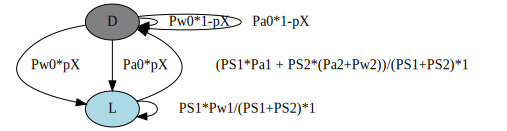

In [9]:
da_graph_light = nx.MultiDiGraph()
da_graph_light.add_nodes_from([("D", {"fillcolor": "grey", "subset":0}), ("L", {"fillcolor": "lightblue", "subset":0})])
edges = [("D", "L", "Pw0", {"p":"pX"}),
         ("D", "D", "Pw0", {"p":"1-pX"}),
         ("D", "L", "Pa0", {"p":"pX"}),
         ("D", "D", "Pa0", {"p":"1-pX"}),
         ("L", "D", "(PS1*Pa1 + PS2*(Pa2+Pw2))/(PS1+PS2)", {"p":1}),
         ("L", "L", "PS1*Pw1/(PS1+PS2)", {"p":1})]
da_graph_light.add_edges_from(edges)
labels = {(edge[0], edge[1], edge[2]):str(edge[2] + "*" + str(edge[3]["p"]) + "   ") for edge in da_graph_light.edges(data = True, keys = True)}
nx.set_edge_attributes(da_graph_light, labels, "label")

D = nx.drawing.nx_agraph.to_agraph(da_graph_light)
D.node_attr.update(style = "filled")
D.layout('dot')

D

One can now calculate the probability to observe a light- or dark-state using the limiting state probabilities from above:
$$
P_D = P_{S0} = \frac{1}{1 + p_X(2-\pi_{a1})}, P_L = P_{S1}+P_{S2} = \frac{p_X(2-\pi_{a1})}{1 + p_X(2-\pi_{a1})}
$$

In [10]:
import sympy as sym

x = sym.Symbol("p_X")
a1 = sym.Symbol("\pi_{a1}")

P_mp1 = sym.Matrix([[1-x, x], [1/(2-a1), (1-a1)/(2-a1)]])

eigs = P_mp1.T.eigenvects()
eig = eigs[0][2][0]
stat_mp1 = sym.simplify((eig/sum(eig)).T)
stat_mp1_l = sym.lambdify([x, a1], stat_mp1) # lambdify for later evaluation
stat_mp1

Matrix([[1/(-\pi_{a1}*p_X + 2*p_X + 1), p_X*(\pi_{a1} - 2)/(\pi_{a1}*p_X - 2*p_X - 1)]])

Only looking at the actions of the agent also results in a two state MP, with rather trivial transition probabilities:
$$
P_A = P_{S_0}\pi_{a0} + P_{S_1}\pi_{a1} + P_{S_2}\pi_{a2} = \frac{\pi_{a0} + p_X\pi_{a1} + p_X(1-\pi_{a1})\pi_{a2}}{1 + p_X(2-\pi_{a1})}, P_W = 1- P_A
$$

In [11]:
import sympy as sym

x = sym.Symbol("p_X")
a0 = sym.Symbol("\pi_{a0}")
a1 = sym.Symbol("\pi_{a1}")
a2 = sym.Symbol("\pi_{a2}")

pa = stat_mdp[0]*a0 + stat_mdp[1]*a1 + stat_mdp[2]*a2
P_mp2 = sym.Matrix([[pa, 1-pa], [pa, 1-pa]])

# P_mp2 is already stationary
stat_mp2 = sym.Matrix([[sym.simplify(pa), sym.simplify(1-pa)]])
stat_mp2_l = sym.lambdify([x, a0, a1, a2], stat_mp2) # lambdify for later evaluation
stat_mp2

Matrix([[(\pi_{a0} + \pi_{a1}*p_X - \pi_{a2}*p_X*(\pi_{a1} - 1))/(-\pi_{a1}*p_X + 2*p_X + 1), (-\pi_{a0} - 2*\pi_{a1}*p_X + \pi_{a2}*p_X*(\pi_{a1} - 1) + 2*p_X + 1)/(-\pi_{a1}*p_X + 2*p_X + 1)]])

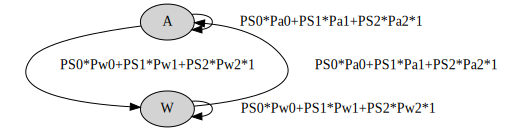

In [12]:
da_graph_action = nx.MultiDiGraph()
da_graph_action.add_nodes_from([("A", {"subset":0}), ("W", {"subset":0})])
edges = [("A", "A", "PS0*Pa0+PS1*Pa1+PS2*Pa2", {"p":1}),
         ("A", "W", "PS0*Pw0+PS1*Pw1+PS2*Pw2", {"p":1}),
         ("W", "A", "PS0*Pa0+PS1*Pa1+PS2*Pa2", {"p":1}),
         ("W", "W", "PS0*Pw0+PS1*Pw1+PS2*Pw2", {"p":1})]
da_graph_action.add_edges_from(edges)
labels = {(edge[0], edge[1], edge[2]):str(edge[2] + "*" + str(edge[3]["p"]) + "   ") for edge in da_graph_action.edges(data = True, keys = True)}
nx.set_edge_attributes(da_graph_action, labels, "label")

D = nx.drawing.nx_agraph.to_agraph(da_graph_action)
D.node_attr.update(style = "filled")
D.layout('dot')

D

One can now also think about combining the two observations, so for example the observer always gets the information about the current state of the light and the action of the agent that brought it to that state.
This will now result in a MP with four states.

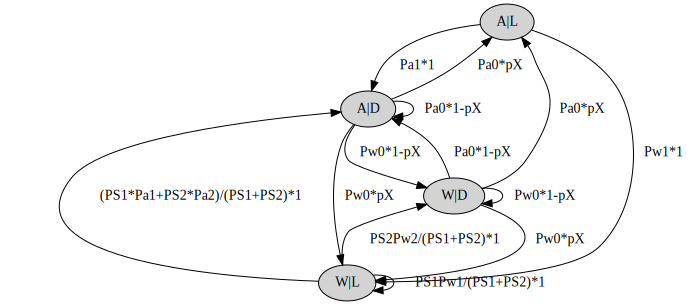

In [ ]:
da_graph_combined = nx.MultiDiGraph()
da_graph_combined.add_nodes_from([("A|L", {"subset":0}), ("A|D", {"subset":0}), ("W|L", {"subset":0}), ("W|D", {"subset":0})])
edges = [#("A|L", "A|L", "0", {"p":1}),
         ("A|L", "A|D", "Pa1", {"p":1}),
         ("A|L", "W|L", "Pw1", {"p":1}),
         #("A|L", "W|D", "0", {"p":1}),
         ("A|D", "A|L", "Pa0", {"p":"pX"}),
         ("A|D", "A|D", "Pa0", {"p":"1-pX"}),
         ("A|D", "W|L", "Pw0", {"p":"pX"}),
         ("A|D", "W|D", "Pw0", {"p":"1-pX"}),
         #("W|L", "A|L", "0", {"p":1}),
         ("W|L", "A|D", "(PS1*Pa1+PS2*Pa2)/(PS1+PS2)", {"p":1}),
         ("W|L", "W|L", "PS1Pw1/(PS1+PS2)", {"p":1}),
         ("W|L", "W|D", "PS2Pw2/(PS1+PS2)", {"p":1}),
         ("W|D", "A|L", "Pa0", {"p":"pX"}),
         ("W|D", "A|D", "Pa0", {"p":"1-pX"}),
         ("W|D", "W|L", "Pw0", {"p":"pX"}),
         ("W|D", "W|D", "Pw0", {"p":"1-pX"})]
da_graph_combined.add_edges_from(edges)
labels = {(edge[0], edge[1], edge[2]):str(edge[2] + "*" + str(edge[3]["p"]) + "   ") for edge in da_graph_combined.edges(data = True, keys = True)}
nx.set_edge_attributes(da_graph_combined, labels, "label")

D = nx.drawing.nx_agraph.to_agraph(da_graph_combined)
D.node_attr.update(style = "filled")
D.layout('dot')

D

In [ ]:
import sympy as sym

x = sym.Symbol("p_X")
a0 = sym.Symbol("\pi_{a0}")
a1 = sym.Symbol("\pi_{a1}")
a2 = sym.Symbol("\pi_{a2}")


ps1 = x / (1+x*(2-a1))
ps2 = x*(1-a1) / (1+x*(2-a1))
# A|L, A|D, W|L, W|D
P = sym.Matrix([[0, a1, 1-a1, 0],
    [a0*x, a0*(1-x), (1-a0)*x, (1-a0)*(1-x)],
    [0, (ps1*a1+ps2*a2)/(ps1+ps2), ps1*(1-a1)/(ps1+ps2), ps2*(1-a2)/(ps1+ps2)],
    [a0*x, a0*(1-x), (1-a0)*x, (1-a0)*(1-x)]]).T
P = sym.simplify(P)
eigs = P.eigenvects()
eig = eigs[0][2][0]
sym.simplify((eig/sum(eig)).T)

Matrix([[0, zoo, 0, zoo]])

The simplified probabilities for each state are then as follows (from Mathematica):
$$
P_{A|L} = \frac{p_X\pi_{a0}}{1+p_X(2+\pi_{a0}(\pi_{a1}-1)^2-\pi_{a1})}, 
$$
$$
P_{W|L} = \frac{p_X(\pi_{a1}-2)(\pi_{a0}\pi_{a1}-1)}{1+p_X(2+\pi_{a0}(\pi_{a1}-1)^2-\pi_{a1})}, 
$$
$$
P_{A|D} = \frac{p_X[\pi_{a0}[\pi_{a1}(\pi_{a1}-1)(\pi_{a2}-1)-1]+\pi_{a2}(1-\pi_{a1})+\pi_{a1}]+\pi_{a0}}{1+p_X(2+\pi_{a0} (\pi_{a1}-1)^2-\pi_{a1})}, 
$$
$$
P_{W|D} = \frac{p_X[\pi_{a1}(\pi_{a2}-1)-\pi_{a2}]+\pi_{a0}[p_X[\pi_{a1}(\pi_{a2}(1-\pi_{a1})+\pi_{a1}-1)+1]-1]+1}{1+p_X(2+\pi_{a0} (\pi_{a1}-1)^2-\pi_{a1})}
$$

Naively, one might for example think, that the probability to get the state $A|L$ would be the probability to be in $S_0$, then act, and the light turning on, so $P_{S_0}\pi_{a0}p_X$. 
$P_{A|L}$ differs from that result by a quadratic expression. (wrong conditional probability?)